In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import pyramid_gaussian
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import label, regionprops, regionprops_table
import cv2
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import shutil, os, time, random, copy
import imageio
import h5py
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
from skimage.transform import rotate, AffineTransform, warp, resize
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
import time
from keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.models import Model

import tensorflow as tf
from tensorflow import keras
import keras
from keras.regularizers import l2
from skimage.measure import label, regionprops, regionprops_table
from keras.applications import MobileNetV2

Using TensorFlow backend.


In [3]:
# Preprocessing Functions for Preprocessing Dataset Information
plot = lambda x: (plt.imshow(x), plt.show())

def Boxplot(ytrue, ypred):
    '''
    This function finds the maximum f1 scores based on a random search grid for thresholds for predict ypred as a correct class.
    '''
    Values = [] # List that will save all the f1 scores
    samples = 10000

    localPred = ypred
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'orange', 'black', 'gray', 'green'])
    print(colors)
    bottom, top = plt.ylim()
    plt.ylim(top=1.0)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=0.0)  # adjust the bottom leaving top unchanged

    for c in range(8):
        #fpr, tpr, thresholds = metrics.roc_curve(ytrue[:, c], localPred[:, c], pos_label=1) # postlabels: number of different labels - 1. In this case is one hot encoding
        local = ytrue[:, c]
        pos = np.where(local==1.0)[0] 
        neg = np.where(local==0.0)[0]
        #print(pos[0])
        TruePos = ytrue[pos,c]
        PredPos = ypred[pos, c]
        TrueNeg = ytrue[neg,c]
        PredNeg = ypred[neg, c]
        plt.boxplot([ PredPos, 0*PredPos ])
        plt.boxplot([ 0*PredNeg, PredNeg  ])
        plt.show()  


def has_diagnosis(text):
    diagnosis=[]
    if ("normal" in text):
      diagnosis.append('N') 
    if ("retinopathy" in text):
        if ("hypertensive" in text):
            diagnosis.append('H') 
        else:
            diagnosis.append('D')
    if ("glaucoma" in text):
        diagnosis.append('G') 
    if ("cataract" in text):
        diagnosis.append('C') 
    if ("age" in text):
        diagnosis.append('A') 
    if ("myopia" in text):
        diagnosis.append('M') 
    if (len(diagnosis)==0):
        diagnosis.append('O')
    return diagnosis   

def norm(lista):
    if ('N' in lista):
        return 1
    else:
        return 0
def hyper (lista):
    if ('H' in lista):
        return 1
    else:
        return 0

def diab (lista):
      if ('D' in lista):
        return 1
      else:
        return 0

def glau (lista):
      if ('G' in lista):
        return 1
      else:
        return 0

def cat (lista):
      if ('C' in lista):
        return 1
      else:
        return 0

def age (lista):
      if ('A' in lista):
        return 1
      else:
        return 0

def myop (lista):
      if ('M' in lista):
        return 1
      else:
        return 0

def ot (lista):
      if ('O' in lista):
        return 1
      else:
        return 0


def train_test_val(name_im, train,test,val):
      if (name_im in train):
        return 'Train'
      if (name_im in test):
        return 'Test'
      if (name_im in val):  
        return 'Validation'
      else:
        return 'NONE'

    
def calcEyeMask(im):
    '''
    This function calculates the eye and background through a thresholding analysis
    im = cv2.imread(path, 0)
    maskEye = calcEyeMask(im)
    '''
    
    im = im.astype(float)
    im = im / 5
    im = 5*im.astype(np.uint8)
    im = im < 10
    im = 1 - im
    im = im.astype(np.uint8)
    return im

def preprocessing2(im):
    '''
    This function preprocess a numpy BGR image based on an GnGnRn normalization
    im = cv2.imread(path) # RGB image
    EyeZoneImage, EyeZonePreprocessed = preprocessing(im) # The output image only contains the eye of the fundus color image
    '''
    try:
        R = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im2 = im.copy()
    except:
        print("This is not an RGB image")
        return None
    mask = calcEyeMask(R) # mask of the eye
    im2, mask = cropper(im2, mask)
    return im2
def filtroAreas2(regions, fil_o, col_o):
    '''
    This function filters the regions (based on the region proposal method of scikit-image: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html) whose areas are greather than a predefined threshold (0.2*fil_o*col_o), and output the BoxesCoordinates that are associated with that regions.
    im = cv2.imread(path, 0)
    binary = im > th 
    labels = label(a)
    props = regionprops(labels)
    BoxesCoordinates = filtroAreas2(props, fil_o, col_o)
    print(BoxesCoordinates)
    Out[]: 
    {
        "X1": [x_initial coordinates of boxes list],
        "X2": [x_final coordinates of boxes list],
        "Y1": [y_initial coordinates of boxes list], 
        "Y2": [y_final coordinates of boxes list],
    }
    '''

    x1 = []
    x2 = []
    y1 = []
    y2 = []
    th = 0.2*fil_o*col_o

    for props in regions:
        minr, minc, maxr, maxc  = props.bbox
        if props.area > th: #and props.area < 1e3:
            x1.append(minr)
            y1.append(minc)
            x2.append(maxr)
            y2.append(maxc)

    X = {}
    X["X1"] = x1
    X["X2"] = x2
    X["Y1"] = y1
    X["Y2"] = y2

    return X

def cropper(im, mask):
    '''
    This function croppes im and mask based on the white values of mask.
    im = cv2.imread(path, 0)
    binary = im > th
    EyeZone, MaskEyeZone = cropper(im, binary)
    '''
    label_img = label(mask)
    regions = regionprops(label_img)
    X = filtroAreas2(regions, mask.shape[0], mask.shape[1])
    x_i, x_f, y_i, y_f = X["X1"][0], X["X2"][0], X["Y1"][0], X["Y2"][0]
    try:
        img2 = im[x_i: x_f, y_i: y_f, :]
        mask2 = mask[x_i: x_f, y_i: y_f]
    except:
        img2 = im[x_i: x_f, y_i: y_f]
        mask2 = mask[x_i: x_f, y_i: y_f]
    return img2, mask2

In [4]:
full_df=pd.read_csv('full_df.csv')
full_df.drop(full_df[full_df['Left-Fundus']=="1209_left.jpg"].index, inplace = True) 
full_df.drop(full_df[full_df['Left-Fundus']=="1370_left.jpg"].index, inplace = True) 
full_df.drop(full_df[full_df['Left-Fundus']=="1730_left.jpg"].index, inplace = True) 
full_df.drop(full_df[full_df['Right-Fundus']=="1398_right.jpg"].index, inplace = True) 

class_names=['N','D','G','C','A','H','M','O']

full_df["left_diag"] = full_df["Left-Diagnostic Keywords"].apply(lambda x: has_diagnosis(x))
full_df["right_diag"] = full_df["Right-Diagnostic Keywords"].apply(lambda x: has_diagnosis(x))
full_df["R_N"]=full_df["right_diag"].apply(lambda x: norm(x))
full_df["R_D"]=full_df["right_diag"].apply(lambda x: diab(x))
full_df["R_G"]=full_df["right_diag"].apply(lambda x: glau(x))
full_df["R_C"]=full_df["right_diag"].apply(lambda x: cat(x))
full_df["R_A"]=full_df["right_diag"].apply(lambda x: age(x))
full_df["R_H"]=full_df["right_diag"].apply(lambda x: hyper(x))
full_df["R_M"]=full_df["right_diag"].apply(lambda x: myop(x))
full_df["R_O"]=full_df["right_diag"].apply(lambda x: ot(x))
full_df["L_N"]=full_df["left_diag"].apply(lambda x: norm(x))
full_df["L_D"]=full_df["left_diag"].apply(lambda x: diab(x))
full_df["L_G"]=full_df["left_diag"].apply(lambda x: glau(x))
full_df["L_C"]=full_df["left_diag"].apply(lambda x: cat(x))
full_df["L_A"]=full_df["left_diag"].apply(lambda x: age(x))
full_df["L_H"]=full_df["left_diag"].apply(lambda x: hyper(x))
full_df["L_M"]=full_df["left_diag"].apply(lambda x: myop(x))
full_df["L_O"]=full_df["left_diag"].apply(lambda x: ot(x))


full_df_R=full_df[['Right-Fundus','R_N','R_D','R_G','R_C','R_A','R_H','R_M','R_O']]
full_df_L=full_df[['Left-Fundus','L_N','L_D','L_G','L_C','L_A','L_H','L_M','L_O']]
full_df_L.columns=['Image_name','N','D','G','C','A','H','M','O']
full_df_R.columns=['Image_name','N','D','G','C','A','H','M','O']
frames=[full_df_L,full_df_R]
Data_full=pd.concat(frames)
Data_full['Image_name']=Data_full['Image_name'].apply(lambda x: './imagenes4/'+str(x))
Data_full.sort_values("Image_name", inplace = True) 
Data_full.drop_duplicates(subset ="Image_name", 
                     keep = 'first', inplace = True)
# Generar una especie de one hot encoding para cada etiqueta
Data_full['powerlabel']=Data_full.apply(lambda x: 128*x['N']+64*x['D']+32*x['G']+16*x['C']+ \
                                        8*x['A']+4*x['H']+2*x['M']+1*x['O'], 
                                        axis=1)

Data_full['powerlabel']=Data_full.apply(lambda x: 128*x['N']+64*x['D']+32*x['G']+16*x['C']+ \
                                        8*x['A']+4*x['H']+2*x['M']+1*x['O'], 
                                        axis=1)

# Data_full['powerlabel'].hist(bins=np.unique(Data_full['powerlabel']))
train=0.9
val=0.03
test=0.07
train_df = pd.DataFrame(columns = ["Image_name"]+class_names)
val_df = pd.DataFrame(columns = ["Image_name"]+class_names)
test_df = pd.DataFrame(columns = ["Image_name"]+class_names)

# Train Test Split
train_inds, test_inds = train_test_split(np.array(list(range(Data_full.shape[0]))),
                                         test_size=1-train,random_state=7)
val_inds, test_inds = train_test_split(np.array(list(range(test_inds.shape[0]))),
                                       test_size=test/(test + val),random_state=8)

train_df = Data_full.iloc[train_inds,:].reset_index(drop=True)
val_df = Data_full.iloc[val_inds,:].reset_index(drop=True)
test_df = Data_full.iloc[test_inds,:].reset_index(drop=True)

# Power Count: Dic-> Posibles Combinaciones, Desde 00000000, 11111111-> Cuantas veces.
# NA------ : 3
# powercount = { "NA------" : 3 }
powercount = {}
powerlabels = np.unique(train_df['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(train_df['powerlabel']==p)


# Data Augmentation: Mirarlo
maxcount = np.max(list(powercount.values())) # cual de todas las combinaciones se repite mas
for p in powerlabels:
    gapnum = maxcount - powercount[p] # distancia
    #print(gapnum)
    # np.where(train_df['powerlabel']==p)[0]: indices
    # np.random.choice(np.where(train_df['powerlabel']==p)[0],size=gapnum) generar un arreglo de gapnum aleatorio basado en los indices
    #iloc: toma el contenido y lo guarda en temp_df como dataframe
    temp_df = train_df.iloc[np.random.choice(np.where(train_df['powerlabel']==p)[0],size=gapnum)] 
    # guardar el dataframe
    train_df = train_df.append(temp_df,ignore_index=True)
    
train_df = train_df.sample(frac=1).reset_index(drop=True) # Resetear los indices para que quede todo en orden

positive_weights = {} # peso de la cantidad de veces que la clase c es 1. 
negative_weights = {} # perso de la cantidad de veces que la clase c es 0.
for c in class_names:
    positive_weights[c] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==1))
    negative_weights[c] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==0))


positive_weights_num = {}
negative_weights_num = {}
i=0
for c in class_names:
    positive_weights_num[i] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==1))
    negative_weights_num[i] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==0))
    i+=1
print("Train Size:" , train_df.shape)
print("Test Size:" , test_df.shape)
print("Val Size:" , val_df.shape)

Train Size: (53480, 10)
Test Size: (471, 10)
Val Size: (201, 10)


In [127]:
clases = ['N','D','G','C','A','H','M','O']
[print(train_df[i].value_counts() ) for i in clases] 

0    3366
1    2676
Name: N, dtype: int64
0    4488
1    1554
Name: D, dtype: int64
0    5761
1     281
Name: G, dtype: int64
0    5775
1     267
Name: C, dtype: int64
0    5773
1     269
Name: A, dtype: int64
0    5876
1     166
Name: H, dtype: int64
0    5808
1     234
Name: M, dtype: int64
0    5332
1     710
Name: O, dtype: int64


[None, None, None, None, None, None, None, None]

In [35]:
full_df[full_df['Left-Fundus']=="1209_left.jpg"]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,R_M,R_O,L_N,L_D,L_G,L_C,L_A,L_H,L_M,L_O


In [5]:
from sklearn.utils import class_weight
import numpy as np


BZ = 32

class DataGeneratorKeras(Sequence):
    # Constructor
    def __init__(self,train = True, augmentation = False, preprocessing_fn = None, batch_size = 32):
        self.train = train
        self.batch_size = batch_size
        self.directory="./imagenes4/"
        self.H = 256
        self.W = 256

        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn

        if self.train:
            self.all_files = train_df
        else:
            self.all_files = val_df
    
    def __len__(self):
        return self.all_files.shape[0]//self.batch_size
    
    def on_epoch_end(self):
        self.all_files = self.all_files.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self, idx):
        images = []#np.array([],dtype=float).reshape((0,self.H,self.W,3))
        labels = [] 
        for i in range(self.batch_size):
            # Realizar el minimo de codigo posible. De ser necesario, es mejor cargar numpy arrays de size batch size
            image = io.imread( self.all_files['Image_name'][idx*self.batch_size+i], as_gray=True ).astype(float)
            image = image.astype(float)
            image = 2*image/255 - 1 
            #image = image/255. # Normalizacion
            y = self.all_files.iloc[idx*self.batch_size+i][class_names].values.astype(np.float32)
            
            # If there is any transform method, apply it onto the image
            if self.augmentation:
                image = rotate(image,np.random.uniform(-5,5),preserve_range=True)
                scale = np.random.uniform(0.9,1.25)
                tx = np.random.uniform(0,3)
                ty = np.random.uniform(0,3)
                image = warp(image,
                             AffineTransform(matrix=np.array([[scale, 0, tx],
                                                              [0,scale,  ty],
                                                              [0,   0,   1]])).inverse,
                             preserve_range=True)
            #RANDOM HORIZONTAL FLIPPING
            if np.random.choice([True,False]):
                image = np.flip(image,axis= 1)
            images.append( np.stack((image,)*3, axis=-1)  )#images = np.append(images,np.expand_dims(image,axis=0),axis=0)
            labels.append(y)
    
        if self.preprocessing_fn:
            images = self.preprocessing_fn(images)/255.
        
        return np.array(images), np.array(labels)


train_datagen = DataGeneratorKeras(train = True, augmentation = False, 
                                   preprocessing_fn = None, batch_size = BZ)
valid_datagen = DataGeneratorKeras(train = False, augmentation = False, 
                                   preprocessing_fn = None, batch_size = BZ)
test_datagen = DataGeneratorKeras(train = False, augmentation = False, 
                                  preprocessing_fn = None, batch_size = BZ)

NUM_CLASSES = 8
fine_tuning = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


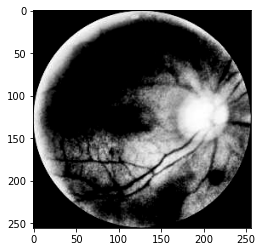

(<matplotlib.image.AxesImage at 0x7f6afdc53e50>, None)

In [6]:
plot(train_datagen[0][0][18])

In [158]:
# Construyendo un modelo basado en transfer learning
baseModel = MobileNetV2(input_shape=(256,256,3),weights="imagenet", include_top=False)
#baseModel.summary()

# Arquitectura base
baseTransfer = keras.Model( inputs = baseModel.input, 
                            outputs = baseModel.layers[-1].output)
for layer in baseTransfer.layers:
    layer.trainable = False

# Funtional Description
dense1 = keras.layers.Dense(512, activation='relu')
dense2 = keras.layers.Dense(256, activation='relu')
output1 = keras.layers.Dense(8, activation='sigmoid', activity_regularizer = l2(0.01)) 

# Defining model
x = GlobalAveragePooling2D()(baseTransfer.output)
x = dense1(x) 
y = dense2(x)
o1 = output1(y)

model = keras.Model(inputs=baseTransfer.input, outputs=o1) 
model.summary()

## Solo si se desea hacer un fine tunning
for layer in model.layers:
    layer.trainable = True

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

In [199]:
lr = [1e-6, 1e-4]
epochs = 1
decay = lr[0]/epochs

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr[0],clipnorm=1),                        
            loss = tf.keras.losses.binary_crossentropy,     
            metrics = [tf.keras.metrics.BinaryAccuracy()] )

In [200]:
history = model.fit(train_datagen, validation_data = valid_datagen, workers = 2 ,
                    epochs = epochs, verbose = 1) 

1671/1671 [==============================] - 472s 283ms/step - loss: 0.0336 - binary_accuracy: 0.9928 - val_loss: 0.1135 - val_binary_accuracy: 0.9740


In [7]:
# Analizing Output
Out_1 = []
Out_2 = []
lista1 = []
lista2 = []
for batch in range( len(valid_datagen) ): 
    out_1 = model.predict( valid_datagen[batch][0] )
    for i in range(32):
        out1 = out_1[i]
        label1 = valid_datagen[batch][1][i]
        Out_2.append( label1 )
        Out_1.append(out1)

lista1 = np.array(Out_1)#np.array(convert_multioutput2array(Out_1)) # np.array(Out_1) #np.array(convert_multioutput2array(Out_1))
lista2 = np.array(Out_2)#np.array(convert_multioutput2array(Out_2)) # np.array(Out_2) #np.array(convert_multioutput2array(Out_2))
print("lista1.shape: ", lista1.shape)
print("lista2.shape: ", lista2.shape)

lista1.shape:  (192, 8)
lista2.shape:  (192, 8)


In [12]:
Th = [0.3, 0.62708324, 0.0061948514, 0.9995086, 0.9899644, 0.9996025, 0.9992472, 0.64908326]
out2 = lista1 > Th 
from sklearn.metrics import classification_report
print(classification_report(lista2, out2))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85        44
           1       0.95      0.86      0.90        21
           2       0.94      0.94      0.94        66
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00        15
           5       1.00      0.77      0.87        13
           6       1.00      0.82      0.90        11
           7       0.94      0.86      0.90        37

   micro avg       0.91      0.90      0.91       210
   macro avg       0.95      0.86      0.90       210
weighted avg       0.92      0.90      0.91       210
 samples avg       0.89      0.90      0.89       210



Normal: 0.9
th_clase1: 0.27470964
Diabetes: 0.8717948717948718
th_clase2: 0.62708324
Glaucoma: 0.9624060150375939
th_clase3: 0.0061948514
Catarata: 1.0
th_clase4: 0.9995086
Age: 1.0
th_clase5: 0.99899644
Hipertension: 0.8695652173913044
th_clase6: 0.9996025
Miopia: 1.0
th_clase7: 0.9992472
Otros: 0.9333333333333332
th_clase8: 0.64908326


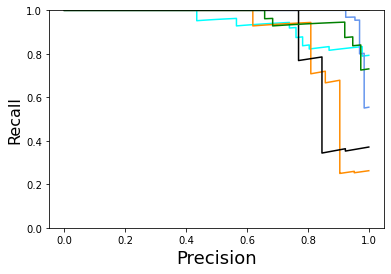

0.9421374296946379
[0.27470964, 0.62708324, 0.0061948514, 0.9995086, 0.99899644, 0.9996025, 0.9992472, 0.64908326]


In [202]:


from itertools import cycle
Classes=['Normal','Diabetes','Glaucoma','Catarata','Age','Hipertension',
         'Miopia','Otros']
def findind_maxF1(ytrue, ypred):
    '''
    This function finds the maximum f1 scores based on a random search grid for thresholds for predict ypred as a correct class.
    '''
    Values = [] # List that will save all the f1 scores
    samples = 10000
    Th = []
    localPred = ypred
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'orange', 'black', 'gray', 'green'])
    print(colors)
    bottom, top = plt.ylim()
    plt.ylim(top=1.0)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=0.0)  # adjust the bottom leaving top unchanged
    F1 = []
    for c in range(8):
        #fpr, tpr, thresholds = metrics.roc_curve(ytrue[:, c], localPred[:, c], pos_label=1) # postlabels: number of different labels - 1. In this case is one hot encoding
        precision, recall, thresholds = precision_recall_curve(ytrue[:, c], localPred[:, c], pos_label=1)
        f1 = np.where(precision + recall==0.0, 0,  2*np.divide( np.multiply(precision, recall), precision + recall))  
        F1.append(f1.max())
        print(Classes[c] + ": " + str( f1[np.argmax(f1)] ))
        print("th_clase"+ str(c+1)+": " + str(thresholds[np.argmax(f1)]) )
        Th.append( thresholds[np.argmax(f1)] )
        #print(thresholds[:4])
        #print("AUC: ", roc_auc_score(ytrue[:, c], localPred[:, c]) )
        plt.plot(recall, precision, color=next(colors))
        plt.xlabel('Precision', fontsize=18)
        plt.ylabel('Recall', fontsize=16)
    plt.show()
    F1 = np.array(F1)
    print(F1.mean())
    print(Th)
findind_maxF1(lista2, lista1)


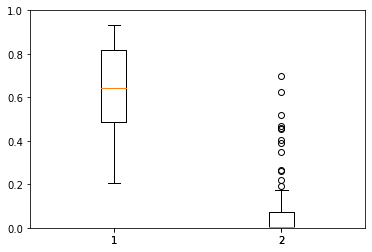

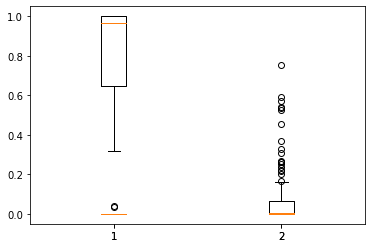

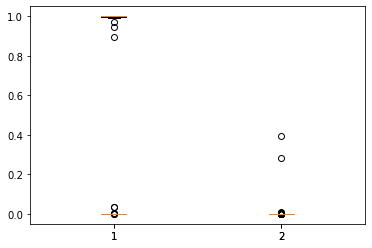

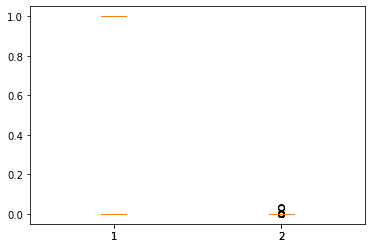

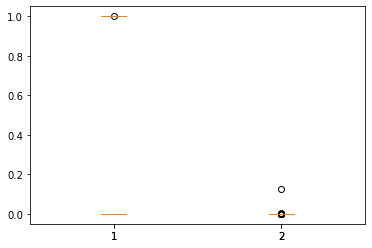

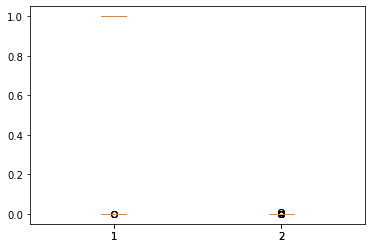

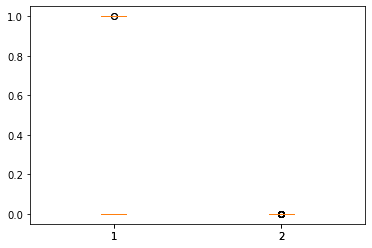

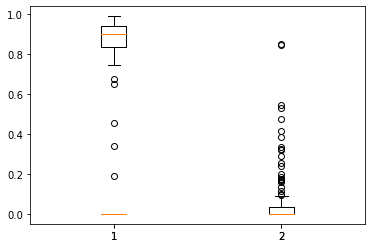

In [203]:
Boxplot(lista2, lista1)

## TESTING PHASE: Comparación con el modelo de retinopatia diabetica y ensamble

In [1]:
import tensorflow as tf
import keras
model = keras.models.load_model("GrayScaleModel3menos1mas13.h5")

Using TensorFlow backend.


In [10]:
Th = [0.4, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.45] #for GaryScaleModel
Th = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
# Ensamble propuesto por Jose: Verificar las imagenes de diabetes como se predicen y en que categoria entran con el 
# modelo entrenado
import os 
from tqdm import tqdm
from funciones import *
#os.system('mkdir MuestrasAlvaro')
base = "Muestras_Dani_Diabetes/"
dir = os.listdir(base)
dir = [base + i for i in dir]
Im_Normal = []
Im_Db1 = []
Im_Db2 = []
Im_Db3 = []
Im_Db4 = []
Tot = [[], [], [], [], []]
Ruido = []
for i in tqdm(range(len(dir))):
    try:
        im = preprocessing( cv2.imread(dir[i]) )
    except:
        Ruido.append( dir[i] )
        continue
    if np.sum(im) == 0.:
        Ruido.append( dir[i] )
        continue
    im = im.astype(float)
    im = im/255.
    im = resize(im, (256, 256), anti_aliasing=True) 
    im = 255*im
    # 'Muestras_Dani_Diabetes/2_train_image2530.tif
    number = (dir[i].split('/')[-1]).split('_')[0]
    Tot[int(number)].append(dir[i])
    if number == '0':
        Im_Normal.append(im)
    elif number == '1':
        Im_Db1.append(im)
    elif number == '2':
        Im_Db2.append(im)
    elif number == '3':
        Im_Db3.append(im)
    else:
        Im_Db4.append(im)
        
        
    
    #Im.append(im)
    #io.imsave( 'MuestrasAlvaro/' + i.split('/')[-1], im.astype(np.uint8) )
    #plot(im)
    
Im_Normal = np.array(Im_Normal)
Im_Db1 = np.array(Im_Db1)
Im_Db2 = np.array(Im_Db2)
Im_Db3 = np.array(Im_Db3)
Im_Db4 = np.array(Im_Db4)
Tot = np.array(Tot)
    

100%|██████████| 390/390 [09:44<00:00,  1.50s/it]


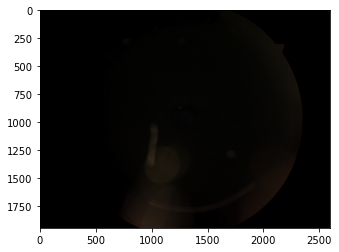

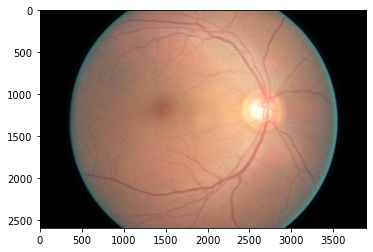

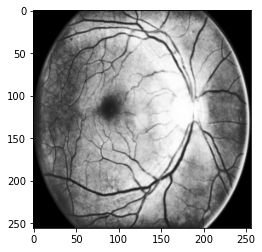

In [62]:
import matplotlib.pyplot as plt
plot = lambda x: (plt.imshow(x), plt.show())
#plot(io.imread(dir[i]))
[plot(io.imread(picture)) for picture in Ruido]
Ruido
plot(io.imread(dir[1]))
plt.imshow(((Im_Normal[0])), cmap= 'gray')

In [14]:
Th = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4] # For grayscale2
Th = [0.53536385, 0.5286444, 0.17966636, 0.5, 0.5, 0.5, 0.5, 0.22650047]
Th = [0.53, 0.6, 0.6, 0.5, 0.5, 0.6, 0.6, 0.5]
Th = [0.27470964, 0.62708324, 0.0061948514, 0.9995086, 0.99899644, 0.9996025, 0.9992472, 0.64908326]
#Th = [0.36673465, 0.79524434, 0.5385031, 0.9971221, 0.19626641, 0.9993468, 0.99899787, 0.5911073]
Th = [0.27014542, 0.6813896, 0.0006144084, 0.9999943, 0.9999858, 0.99999297, 0.99989724, 0.6762402]#ultimo probabilisto
Th = [0.6, 0.58, 0.5, 0.9999943, 0.5, 0.5, 0.5, 0.5] 
Im_Normal = Im_Normal.astype(np.uint8)
Im_Db1 = Im_Db1.astype(np.uint8)
Im_Db2 = Im_Db2.astype(np.uint8)
Im_Db3 = Im_Db3.astype(np.uint8)
Im_Db4 = Im_Db4.astype(np.uint8)
#Tot = np.array(Tot)

Im_Normal2 = 2*Im_Normal.astype(float)/255-1
Im_Db12 = 2*Im_Db1.astype(float)/255-1
Im_Db22 = 2*Im_Db2.astype(float)/255-1
Im_Db32 = 2*Im_Db3.astype(float)/255-1
Im_Db42 = 2*Im_Db4.astype(float)/255-1
#Tot2 = 2*Tot/255-1

outN = SoftMaxToOneColumn(model.predict(np.stack((Im_Normal,)*3, axis=-1))) 
out1 = SoftMaxToOneColumn(model.predict(np.stack((Im_Db12,)*3, axis=-1)))
out2 = SoftMaxToOneColumn(model.predict(np.stack((Im_Db22,)*3, axis=-1)))
out3 = SoftMaxToOneColumn(model.predict(np.stack((Im_Db32,)*3, axis=-1)))
out4 = SoftMaxToOneColumn(model.predict(np.stack((Im_Db42,)*3, axis=-1)))

out2N = outN > Th
out21 = out1 > Th
out22 = out2 > Th
out23 = out3 > Th
out24 = out4 > Th

# Imprimiendo resultados por cada una de las clases
L = [out2N, out21, out22, out23, out24]
path = []
k = 0
Num = 80
for out in L:
    print((  np.round(100*np.sum(out[:, 0])/Num,2), 
           np.round(100*np.sum(out[:, 1])/Num,2),
           np.round(100*np.sum(out[:, 2])/Num,2),
           np.round(100*np.sum(out[:, 3])/Num,2),
           np.round(100*np.sum(out[:, 4])/Num,2),
           np.round(100*np.sum(out[:, 5])/Num,2),
           np.round(100*np.sum(out[:, 6])/Num,2),
           np.round(100*np.sum(out[:, 7])/Num,2)
          ))
    for i in range(30):
        if( out[i, 0] == 1.0 ):
            path.append(Tot[k][i])
    k += 1
path1 = path
#print(path1)

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(72.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5)
(36.25, 53.75, 0.0, 0.0, 1.25, 0.0, 0.0, 0.0)
(12.5, 80.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0)
(13.75, 50.0, 2.5, 0.0, 0.0, 1.25, 1.25, 12.5)


In [52]:
out[0,:]

array([False, False, False, False, False, False, False, False])

In [12]:
import requests
clases = {'Normal': 0, 'Mild NPDR': 0,  'Moderate NPDR': 0, 
          'Severe NPDR': 0, 'PDR': 0}
path2 = []
k = 0
for i in range( out2N.shape[0] ):
        path = Tot[0][i]
        obj = {'message': "/home/jupyter/Daniel/"+path}
        #print(obj)
        x = requests.post("http://0.0.0.0:8081//prediction", json = obj)
        #print((x.json())["prediction"])
        if((x.json())["prediction"] == "Normal"):
            path2.append(path)
        clases[(x.json())["prediction"]] += 100/Num
        clases[(x.json())["prediction"]] = round(clases[(x.json())["prediction"]], 2)
print(clases)
for j in range(1, 5):
    clases = {'Normal': 0, 'Mild NPDR': 0,  'Moderate NPDR': 0, 
          'Severe NPDR': 0, 'PDR': 0}
    for i in range( eval("out2"+str(j)).shape[0] ):
        path = Tot[j][i]
        obj = {'message': "/home/jupyter/Daniel/"+path}
        #print(obj)
        x = requests.post("http://0.0.0.0:8081//prediction", json = obj)
        if((x.json())["prediction"] == "Normal"):
            path2.append(path)
        clases[(x.json())["prediction"]] += 100/Num
        clases[(x.json())["prediction"]] = round(clases[(x.json())["prediction"]], 2)
        #break
    print(clases)
#print(path2)

    

{'Normal': 77.5, 'Mild NPDR': 10.0, 'Moderate NPDR': 1.25, 'Severe NPDR': 1.25, 'PDR': 5.0}
{'Normal': 86.25, 'Mild NPDR': 7.5, 'Moderate NPDR': 3.75, 'Severe NPDR': 0, 'PDR': 0}
{'Normal': 57.5, 'Mild NPDR': 21.25, 'Moderate NPDR': 16.25, 'Severe NPDR': 0, 'PDR': 1.25}
{'Normal': 20.0, 'Mild NPDR': 10.0, 'Moderate NPDR': 42.5, 'Severe NPDR': 8.75, 'PDR': 17.5}
{'Normal': 22.5, 'Mild NPDR': 5.0, 'Moderate NPDR': 17.5, 'Severe NPDR': 5.0, 'PDR': 48.75}


In [53]:
list(clases.keys())

['Normal', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'PDR']

In [16]:
def EnsuringNormalDiabetesPrediction(out, path):
    CONDITION_1 = np.sum(out) == 0. # IF NONE CATEGORY
    CONDITION_2 = out[0] == 1. # IF normal
    CONDITION_3 = out[7] == 1. # IF Others
    
    if(CONDITION_1 or CONDITION_2 or CONDITION_3):
        obj = {'message': "/home/jupyter/Daniel/"+path}
        x = requests.post("http://0.0.0.0:8081//prediction", json = obj)
        Class = (x.json())["prediction"] # Availables: ['Normal', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'PDR']
        #print("Class: ", Class)
        if( Class == "Normal"):
            return np.array([ 1,0,0,0,0,0,0,out[7] ])
        else:
            return np.array([ 0,1,0,0,0,0,0,out[7] ])
    else:
        return out
            
k = 0
for out in L:
    LocalPrediction = []
    l = 0
    for vector in out:
        LocalPrediction.append( EnsuringNormalDiabetesPrediction(vector, Tot[k][l]) )
        l += 1
    #break
    LocalPrediction = np.array(LocalPrediction)
    print((    np.round(100*np.sum(LocalPrediction[:, 0])/Num,2), 
               np.round(100*np.sum(LocalPrediction[:, 1])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 2])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 3])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 4])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 5])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 6])/Num,2),
               np.round(100*np.sum(LocalPrediction[:, 7])/Num,2)
          ))
    k += 1



(77.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(68.75, 28.75, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5)
(31.25, 63.75, 0.0, 0.0, 1.25, 0.0, 0.0, 0.0)
(6.25, 91.25, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0)
(10.0, 83.75, 2.5, 0.0, 0.0, 1.25, 1.25, 12.5)


In [16]:
import os
dir = ["Muestras_Dani_Diabetes/" + i for i in os.listdir("Muestras_Dani_Diabetes/")]
for i in range(10):
    os.system("mv "+ dir[len(dir)-i-1] + " " + "ImagenesAlv/" + dir[len(dir)-i-1].split('/')[-1])
    print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
!zip -r ImagenesPrueba.zip ImagenesAlv/

updating: ImagenesAlv/ (stored 0%)
  adding: ImagenesAlv/0_train_image5360.jpeg (deflated 10%)
  adding: ImagenesAlv/1_train_image1979.jpeg (deflated 12%)
  adding: ImagenesAlv/4_train_image3914.jpeg (deflated 5%)
  adding: ImagenesAlv/0_train_image9491.jpeg (deflated 5%)
  adding: ImagenesAlv/1_train_image13547.jpeg (deflated 9%)
  adding: ImagenesAlv/2_train_image13254.jpeg (deflated 6%)
  adding: ImagenesAlv/0_train_image8574.jpeg (deflated 12%)
  adding: ImagenesAlv/0_train_image12251.jpeg (deflated 4%)
  adding: ImagenesAlv/2_train_image10655.jpeg (deflated 3%)
  adding: ImagenesAlv/2_train_image5163.jpeg (deflated 10%)


In [6]:
# DF1 = pd.DataFrame(path1)
# DF2 = pd.DataFrame(path2)
# frames = [DF1, DF2]
# result = pd.concat(frames,ignore_index=True).drop_duplicates().reset_index(drop=True)
# result.to_string

In [7]:
# len(path2)#+len(path2)

In [8]:
# #print(result.to_string())
# # # Total items starting with F
# # S.str.count(r'(^F.*)').sum()
# result1 = result[(~result[0].isin(DF1[0]))].reset_index(drop=True)
# result1[result1.str(r'(^0.*)')==True]

## ENTRENAMIENTO MULTICLASS MULTILABEL CON ENFOQUE PROBABILISTICO

In [5]:
from sklearn.utils import class_weight
import numpy as np


BZ = 32

class DataGeneratorKeras(Sequence):
    # Constructor
    def __init__(self,train = True, augmentation = False, preprocessing_fn = None, batch_size = 32):
        self.train = train
        self.batch_size = batch_size
        self.directory="./imagenes4/"
        self.H = 256
        self.W = 256

        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn

        if self.train:
            self.all_files = train_df
        else:
            self.all_files = val_df
    
    def __len__(self):
        return self.all_files.shape[0]//self.batch_size
    
    def on_epoch_end(self):
        self.all_files = self.all_files.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self, idx):
        images = []#np.array([],dtype=float).reshape((0,self.H,self.W,3))
        labels = [] 
        O1, O2, O3, O4, O5, O6, O7, O8 = [], [], [], [], [], [], [], []
        for i in range(self.batch_size):
            # Realizar el minimo de codigo posible. De ser necesario, es mejor cargar numpy arrays de size batch size
            image = io.imread( self.all_files['Image_name'][idx*self.batch_size+i], as_gray=True ).astype(float)
            image = image.astype(float)
            image = 2*image/255 - 1 
            #image = image/255. # Normalizacion
            y = self.all_files.iloc[idx*self.batch_size+i][class_names]#.values.astype(np.float32)
            Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8 = y
            O1.append( tf.one_hot(Y1, depth=2) )  
            O2.append( tf.one_hot(Y2, depth=2) ) 
            O3.append( tf.one_hot(Y3, depth=2) )  
            O4.append( tf.one_hot(Y4, depth=2) )  
            O5.append( tf.one_hot(Y5, depth=2) ) 
            O6.append( tf.one_hot(Y6, depth=2) )  
            O7.append( tf.one_hot(Y7, depth=2) )  
            O8.append( tf.one_hot(Y8, depth=2) )  
            
            
            # If there is any transform method, apply it onto the image
            if self.augmentation:
                image = rotate(image,np.random.uniform(-5,5),preserve_range=True)
                scale = np.random.uniform(0.9,1.25)
                tx = np.random.uniform(0,3)
                ty = np.random.uniform(0,3)
                image = warp(image,
                             AffineTransform(matrix=np.array([[scale, 0, tx],
                                                              [0,scale,  ty],
                                                              [0,   0,   1]])).inverse,
                             preserve_range=True)
            #RANDOM HORIZONTAL FLIPPING
            if np.random.choice([True,False]):
                image = np.flip(image,axis= 1)
            images.append( np.stack((image,)*3, axis=-1)  )#images = np.append(images,np.expand_dims(image,axis=0),axis=0)
            
        O1 = np.array(O1)
        O2 = np.array(O2)
        O3 = np.array(O3)
        O4 = np.array(O4)
        O5 = np.array(O5)
        O6 = np.array(O6)
        O7 = np.array(O7)
        O8 = np.array(O8)
        
        labels.append(O1)
        labels.append(O2)
        labels.append(O3)
        labels.append(O4)
        labels.append(O5)
        labels.append(O6)
        labels.append(O7)
        labels.append(O8)
    
        if self.preprocessing_fn:
            images = self.preprocessing_fn(images)/255.
        
        return np.array(images), labels


train_datagen = DataGeneratorKeras(train = True, augmentation = False, 
                                   preprocessing_fn = None, batch_size = BZ)
valid_datagen = DataGeneratorKeras(train = False, augmentation = False, 
                                   preprocessing_fn = None, batch_size = BZ)
test_datagen = DataGeneratorKeras(train = False, augmentation = False, 
                                  preprocessing_fn = None, batch_size = BZ)

NUM_CLASSES = 8
fine_tuning = False

In [12]:
model = []

In [8]:
model = keras.models.load_model("GrayScaleModel3menos1mas13.h5")
# Construyendo un modelo basado en transfer learning
#baseModel.summary()

# Arquitectura base
baseTransfer = keras.Model( inputs = model.input, 
                            outputs = model.layers[-2].output)
for layer in baseTransfer.layers:
    layer.trainable = False
    
#baseTransfer.summary()
# Funtional Description
output1 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.008)) 
output2 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.008))
output3 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.008))
output4 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.03))
output5 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.008))
output6 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.03))
output7 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.03))
output8 = keras.layers.Dense(2, activation='softmax', activity_regularizer = l2(0.03))

# Defining model
o1 = output1(baseTransfer.output)
o2 = output2(baseTransfer.output)
o3 = output3(baseTransfer.output)
o4 = output4(baseTransfer.output)
o5 = output5(baseTransfer.output)
o6 = output6(baseTransfer.output)
o7 = output7(baseTransfer.output)
o8 = output8(baseTransfer.output)

model = keras.Model(inputs=baseTransfer.input, outputs=[o1, o2, o3, o4, o5, o6, o7, o8]) 
#model.summary()

# ## Solo si se desea hacer un fine tunning
# for layer in model.layers:
#     layer.trainable = True

In [6]:
model = keras.models.load_model("MultiClassMultiLabelProbabilistic.h5")

In [15]:
lr = [1e-5, 1e-4]
epochs = 1
decay = lr[0]/epochs

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr[0],clipnorm=1),                        
            loss = tf.keras.losses.binary_crossentropy,     
            metrics = [tf.keras.metrics.BinaryAccuracy()] )

history = model.fit(train_datagen, validation_data = valid_datagen, workers = 2 ,
                    epochs = epochs, verbose = 1) 

1671/1671 [==============================] - 415s 248ms/step - loss: 0.2821 - dense_8_loss: 0.0555 - dense_9_loss: 0.0428 - dense_10_loss: 0.0012 - dense_11_loss: 4.8689e-04 - dense_12_loss: 4.9088e-05 - dense_13_loss: 1.2480e-04 - dense_14_loss: 9.9620e-06 - dense_15_loss: 0.0308 - dense_8_binary_accuracy: 0.9736 - dense_9_binary_accuracy: 0.9819 - dense_10_binary_accuracy: 0.9997 - dense_11_binary_accuracy: 0.9998 - dense_12_binary_accuracy: 1.0000 - dense_13_binary_accuracy: 1.0000 - dense_14_binary_accuracy: 1.0000 - dense_15_binary_accuracy: 0.9883 - val_loss: 1.1103 - val_dense_8_loss: 0.1628 - val_dense_9_loss: 0.1342 - val_dense_10_loss: 0.2840 - val_dense_11_loss: 3.1545e-06 - val_dense_12_loss: 7.7175e-05 - val_dense_13_loss: 0.2068 - val_dense_14_loss: 0.0690 - val_dense_15_loss: 0.1050 - val_dense_8_binary_accuracy: 0.9323 - val_dense_9_binary_accuracy: 0.9531 - val_dense_10_binary_accuracy: 0.9688 - val_dense_11_binary_accuracy: 1.0000 - val_dense_12_binary_accuracy: 1.000

In [7]:
# Analizing Output
def SoftMaxToOneColumn(objective):
    PREDICTIONS = []
    ARRAY = objective.copy()
    for i in range( len(ARRAY) ):
        softMaxLayerBefore = ARRAY[i]
        softMaxLayer = softMaxLayerBefore[:,1]
        PREDICTIONS.append(softMaxLayer)
    PREDICTIONS = (np.array(PREDICTIONS).swapaxes(0,1))
    return PREDICTIONS

Out_1 = []
Out_2 = []
lista1 = []
lista2 = []
for batch in range( len(valid_datagen) ): 
    objective = valid_datagen[batch][1]
    out_1 = model.predict( valid_datagen[batch][0] )
    tempObj = SoftMaxToOneColumn(objective)
    label = SoftMaxToOneColumn(out_1)
    for i in range(32):
        Out_2.append( tempObj[i] )
        Out_1.append(label[i])

lista1 = np.array(Out_1)#np.array(convert_multioutput2array(Out_1)) # np.array(Out_1) #np.array(convert_multioutput2array(Out_1))
lista2 = np.array(Out_2)#np.array(convert_multioutput2array(Out_2)) # np.array(Out_2) #np.array(convert_multioutput2array(Out_2))
print("lista1.shape: ", lista1.shape)
print("lista2.shape: ", lista2.shape)

lista1.shape:  (192, 8)
lista2.shape:  (192, 8)


Normal: 0.8674698795180724
th_clase1: 0.77016586
Diabetes: 0.8717948717948718
th_clase2: 0.5806618
Glaucoma: 0.9618320610687022
th_clase3: 8.302973e-05
Catarata: 1.0
th_clase4: 0.99999046
Age: 1.0
th_clase5: 0.99995875
Hipertension: 0.8695652173913044
th_clase6: 0.9998288
Miopia: 0.9523809523809523
th_clase7: 0.99969304
Otros: 0.8860759493670887
th_clase8: 0.17407478


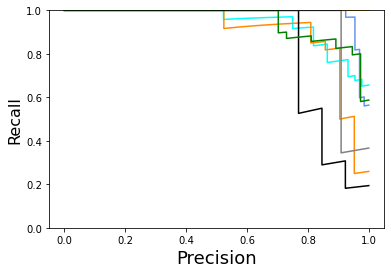

0.9261398664401239
[0.77016586, 0.5806618, 8.302973e-05, 0.99999046, 0.99995875, 0.9998288, 0.99969304, 0.17407478]


In [8]:
from itertools import cycle
Classes=['Normal','Diabetes','Glaucoma','Catarata','Age','Hipertension',
         'Miopia','Otros']
def findind_maxF1(ytrue, ypred):
    '''
    This function finds the maximum f1 scores based on a random search grid for thresholds for predict ypred as a correct class.
    '''
    Values = [] # List that will save all the f1 scores
    samples = 10000
    Th = []
    localPred = ypred
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'orange', 'black', 'gray', 'green'])
    print(colors)
    bottom, top = plt.ylim()
    plt.ylim(top=1.0)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=0.0)  # adjust the bottom leaving top unchanged
    F1 = []
    for c in range(8):
        #fpr, tpr, thresholds = metrics.roc_curve(ytrue[:, c], localPred[:, c], pos_label=1) # postlabels: number of different labels - 1. In this case is one hot encoding
        precision, recall, thresholds = precision_recall_curve(ytrue[:, c], localPred[:, c], pos_label=1)
        f1 = np.where(precision + recall==0.0, 0,  2*np.divide( np.multiply(precision, recall), precision + recall))  
        F1.append(f1.max())
        print(Classes[c] + ": " + str( f1[np.argmax(f1)] ))
        print("th_clase"+ str(c+1)+": " + str(thresholds[np.argmax(f1)]) )
        Th.append( thresholds[np.argmax(f1)] )
        #print(thresholds[:4])
        #print("AUC: ", roc_auc_score(ytrue[:, c], localPred[:, c]) )
        plt.plot(recall, precision, color=next(colors))
        plt.xlabel('Precision', fontsize=18)
        plt.ylabel('Recall', fontsize=16)
    plt.show()
    F1 = np.array(F1)
    print(F1.mean())
    print(Th)
findind_maxF1(lista2, lista1)

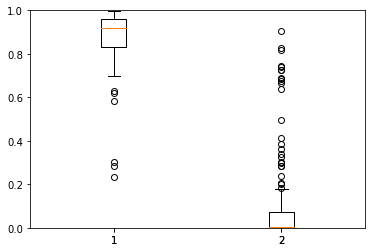

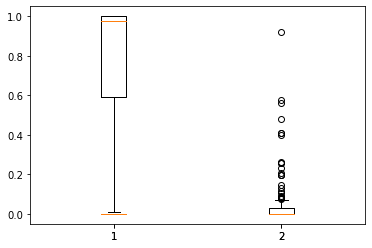

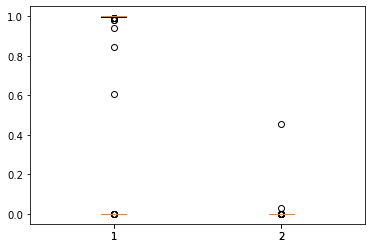

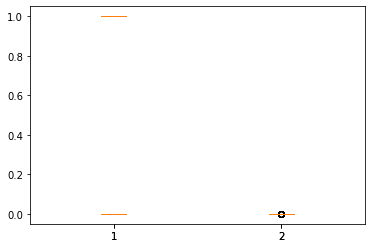

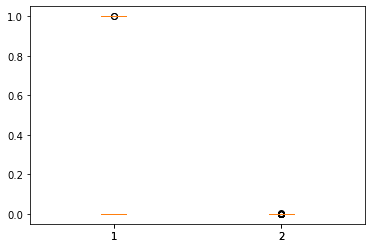

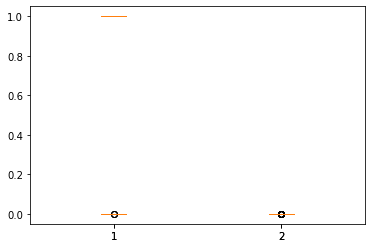

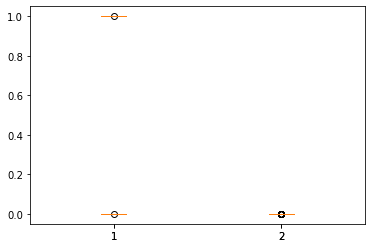

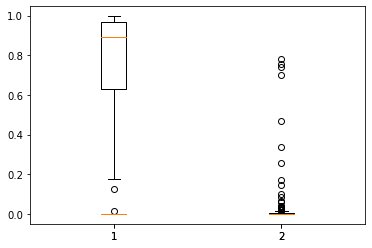

In [9]:
Boxplot(lista2, lista1)

In [48]:
model.save("GrayScaleModel3menos1mas13.h5")